The link to my drive folder is [here.](https://drive.google.com/drive/folders/1s5varOa81vPRIEciUCThNGaZnhycIUhR?usp=sharing) It has ll the data in it.

In [ ]:
%%bash

pip -q install sentence-transformers
pip -q install -U skorch

In [ ]:
import pandas as pd
import numpy as np
import json
from typing import *
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

DIR = "drive/My Drive/UROP Summer 2020/"
DATA_DIR = DIR +"data/"

This loads the static features and delays.

In [ ]:
USE_COORDS = False

DELAY_COL = "Initial Delay (mins)"
TEXT_COL = "Fault Description"

if USE_COORDS:
    feature_file = DATA_DIR + "static_features_one_hot.csv" #use "static_features.csv" for the original 22 features
    incident_file = DATA_DIR + "selected_incidents.csv"
    incident_df = pd.read_csv(incident_file)
else:
    feature_file = DATA_DIR + "static_features_one_hot_no_coords.csv" 
    incident_file = DATA_DIR + "incident_reports_tab.txt"
    incident_df = pd.read_csv(incident_file, delimiter="\t", encoding='latin_1')


static_features_df = pd.read_csv(feature_file, index_col=0)
static_features = static_features_df.to_numpy()
delays = incident_df[DELAY_COL].to_numpy()



This cell filters out delays of 0 and greater than 120.

In [ ]:
delay_mask = np.logical_and(delays > 0, delays <= 120)
delays = delays[delay_mask]
static_features = static_features[delay_mask]

In [ ]:
print(np.count_nonzero(np.logical_and(delays > 0, delays <= 120)))

18909


In [ ]:
print(static_features.shape)
print(delays.shape)
print(static_features_df)

(18909, 354)
(18909,)
       Bakerloo  C&H  Central  ...  WOODFORD  WOODFORD SIDINGS  WOODSIDE PARK
0             0    0        0  ...         0                 0              0
1             0    0        1  ...         0                 0              0
2             0    0        0  ...         0                 0              0
3             0    0        1  ...         0                 0              0
4             1    0        0  ...         0                 0              0
...         ...  ...      ...  ...       ...               ...            ...
23723         0    0        0  ...         0                 0              0
23724         0    1        0  ...         0                 0              0
23725         0    0        0  ...         0                 0              0
23726         0    0        0  ...         0                 0              0
23727         0    0        0  ...         0                 0              0

[23728 rows x 354 columns]


These next cells can be used to create LDA models

In [ ]:
from gensim.models.ldamodel import LdaModel
from gensim.sklearn_api import LdaTransformer
from gensim.corpora.dictionary import Dictionary
from gensim.parsing.preprocessing import preprocess_documents

Remove the delay from the text and tokenize it

In [ ]:
incident_index = pd.Index(incident_df[TEXT_COL][delay_mask])

def remove_delay(text: str):
    delay = delays[incident_index.get_loc(text)]
    return text.replace(" " + str(delay) + " ", " ")

text_without_delays = incident_df[TEXT_COL][delay_mask].apply(remove_delay).to_numpy()

In [ ]:
print(text_without_delays)

['Delayed arrival - due to customer partialy accessing track. Station staff adv to attend WB. DIC. Details taken from DSR.'
 'E402 was delayed after departing Liverpool Street station due to a low level Passenger Emergency Alarm being operated in car four. The train`s brakes were applied and E402 was stopped with four cars out of the platform. The Train Operator used the talkback facility, but there was no response and contacted the Service Controller who tasked Station Staff to attend and board the train via the last car to reset the PEA. Station Supervisors boarded the train the train as instructed and located a customer who admitted to accidentally operating the PEA. PEA was reset by the Train Operator. Station Staff left the train via the same door used to board and then closed it. E402 was then able to continue to Aldgate Low Level PEA accidentally operated in car four (24038) by customer. Station Staff in attendance. Reset by Train Operator.'
 'At 03:12 hours eastbound Central li

In [ ]:
processed_text_without_delays = preprocess_documents(text_without_delays)
#print(processed_text_without_delays)

In [ ]:
print(processed_text_without_delays[0])

['delai', 'arriv', 'custom', 'partiali', 'access', 'track', 'station', 'staff', 'adv', 'attend', 'dic', 'detail', 'taken', 'dsr']


In [ ]:
dictionary = Dictionary(processed_text_without_delays)

corpus = [dictionary.doc2bow(tokens) for tokens in processed_text_without_delays]

In [ ]:
num_topics = 10
lda_model = LdaTransformer(id2word=dictionary, alpha="auto", num_topics=num_topics)

# lda_features = lda_model.fit_transform(corpus)

I saved the features I found from the grid search to this file.

In [ ]:
lda_10_features_file = DATA_DIR + "lda_features_ten_7_26_20.csv"
lda_20_features_file = DATA_DIR + "lda_features_20_7_26_20.csv"

In [ ]:
with open(lda_features_file, "x") as file:
    np.savetxt(file, lda_features)

In [ ]:
lda_model.gensim_model.show_topics()

[(0,
  '0.098*"ref" + 0.047*"stop" + 0.047*"esc" + 0.046*"apjnp" + 0.041*"lift" + 0.038*"srq" + 0.029*"servic" + 0.025*"non" + 0.023*"escal" + 0.021*"station"'),
 (1,
  '0.085*"door" + 0.055*"train" + 0.041*"close" + 0.033*"open" + 0.022*"delai" + 0.021*"car" + 0.019*"depart" + 0.019*"station" + 0.016*"oper" + 0.013*"platform"'),
 (2,
  '0.071*"train" + 0.037*"signal" + 0.035*"oper" + 0.022*"servic" + 0.017*"delai" + 0.015*"caus" + 0.014*"control" + 0.013*"incid" + 0.011*"investig" + 0.010*"eastbound"'),
 (3,
  '0.056*"track" + 0.040*"current" + 0.034*"traction" + 0.031*"delai" + 0.030*"street" + 0.029*"train" + 0.022*"victoria" + 0.018*"platform" + 0.018*"protect" + 0.018*"switch"'),
 (4,
  '0.061*"train" + 0.048*"custom" + 0.031*"station" + 0.025*"delai" + 0.024*"platform" + 0.023*"passeng" + 0.022*"staff" + 0.019*"pea" + 0.017*"oper" + 0.017*"depart"'),
 (5,
  '0.046*"signal" + 0.025*"train" + 0.023*"clear" + 0.023*"delai" + 0.019*"line" + 0.016*"point" + 0.016*"servic" + 0.015*"fai

These cells get the RoBERTa embeddings and apply PCA to them.

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
bert_model = SentenceTransformer("roberta-base-nli-mean-tokens")

100%|██████████| 459M/459M [00:26<00:00, 17.2MB/s]


In [ ]:
bert_f_list = bert_model.encode(text_without_delays, batch_size=32, show_progress_bar=True)

In [ ]:
bert_features_full = np.transpose(np.column_stack(bert_f_list))

print(bert_features_full.shape)

(18909, 768)


In [ ]:
bert_full_file = DATA_DIR + "bert_features_full_7_26_20.csv"

In [ ]:
with open(bert_full_file, "x") as file:
    np.savetxt(file, bert_features_full)

This cell loads lda and BERT features from files.

In [ ]:
with open(bert_full_file) as file:
    bert_features_full  = np.loadtxt(file)
with open(lda_10_features_file) as file:
    lda_10_features = np.loadtxt(file)
with open(lda_20_features_file) as file:
    lda_20_features = np.loadtxt(file)

In [ ]:
num_bert_components = 32
pca = PCA(num_bert_components)
bert_features = pca.fit_transform(bert_features_full)

Here ia where the model testing is.

In [ ]:
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate
import sklearn.metrics
from sklearn.model_selection import train_test_split

In [ ]:
static_lda_features = np.column_stack([static_features, lda_10_features])
static_lda_bert_features = np.column_stack([static_features, lda_10_features, bert_features])
scaled_static_lda_bert_features = scale(static_lda_bert_features)

In [ ]:
print(static_features.shape)

(18909, 354)


In [ ]:
print(bert_features.shape)
print(bert_features)

(18909, 32)
[[-1.09412091  0.78044054  7.1870989  ... -0.47510479  1.04429641
   0.15605558]
 [-2.7214045   1.83282107 -0.46022389 ...  0.83551366  1.02851003
  -1.50766594]
 [-6.2776755   3.05515453 -0.40703806 ...  0.52123203  0.32052065
  -0.15342243]
 ...
 [-3.30428426  0.88402292 -0.40145678 ...  0.11992886  0.38064178
   0.7948666 ]
 [ 9.20408884  1.43828585 -7.37230998 ... -0.37399994 -0.81151418
   0.19298334]
 [-4.91451091  2.66841531  2.43339478 ... -1.49958735  1.43817459
  -0.3764382 ]]


In [ ]:
print(static_lda_features.shape)
print(static_lda_features)

print(static_lda_bert_features.shape)
print(static_lda_bert_features)

(18909, 364)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.38638067 0.190428   0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(18909, 1132)
[[ 0.          0.          0.         ... -2.55962038  0.34716728
   0.96678364]
 [ 0.          0.          0.         ... -2.72907805  0.15614244
   1.27267921]
 [ 0.          0.          1.         ... -2.37259173  0.19864403
   1.23603284]
 ...
 [ 0.          0.          0.         ... -2.83527732  0.62750232
   1.08321285]
 [ 0.          1.          0.         ... -2.85176849  0.48809683
   0.66545552]
 [ 0.          0.          0.         ... -2.14675093  0.11174943
   1.16286147]]


In [ ]:
estimators = {"LinearRegression": LinearRegression, "SVM": SVR, "MultiLayeredPerceptron": MLPRegressor, 
              "NearestNeighbors": KNeighborsRegressor, "DecisionTree": DecisionTreeRegressor, "RandomForest": RandomForestRegressor}
features = {"Static": static_features, "LDA": lda_10_features, "BERT": bert_features, "Static+LDA": static_lda_features, "Static+LDA+BERT":static_lda_bert_features}

In [ ]:
estim_feats_seen = {}

This will put the metrics and models trained into the results dict. See the doc for [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) for more info.

In [ ]:
LOG_DELAYS = False

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def exp_of(score_func):
    return lambda y_true, y_pred: score_func(np.exp(y_true), np.exp(y_pred))

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mae_scorer = "neg_mean_absolute_error"
rmse_scorer = "neg_root_mean_squared_error"

cnn_metrics = {"neg_mean_absolute_error": mae_scorer,
               "neg_root_mean_squared_error": rmse_scorer,
               "neg_mean_absolute_percentage_error": mape_scorer}

if LOG_DELAYS:
    mape_scorer = make_scorer(exp_of(mean_absolute_percentage_error), greater_is_better=False)
    mae_scorer = make_scorer(exp_of(mean_absolute_error), greater_is_better=False)
    rmse_scorer = make_scorer(exp_of(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False)),
                              greater_is_better=False)

regression_metrics = {"neg_mean_absolute_error": mae_scorer,
               "neg_root_mean_squared_error": rmse_scorer,
               "neg_mean_absolute_percentage_error": mape_scorer}

delays_to_use = np.log(delays) if LOG_DELAYS else delays

In [ ]:
results = {}

This cell computes cross validated metrics using all the data.

In [ ]:
def output_score(metric, score):
  out = score.mean()
  if "neg" in metric:
    out *= -1
  return out


for estimator_name, estimator in estimators.items():
    if estimator_name not in estim_feats_seen:
        estim_feats_seen[estimator_name] = set()
    for feature_name, feature in features.items():
        if feature_name in estim_feats_seen[estimator_name]:
            continue
        if estimator_name not in results:
            results[estimator_name] = {}
        print("Evaluating", estimator_name, "on", feature_name)
        regression_model = Pipeline([("scaler", StandardScaler()), ("estimator", estimator())])
        scores = cross_validate(regression_model, feature, delays_to_use, cv=10, 
                                scoring=regression_metrics, return_estimator=False,
                                return_train_score=False)
        results[estimator_name][feature_name] = scores
        estim_feats_seen[estimator_name].add(feature_name)
        print(estimator_name, ",", feature_name, ":", {metric: output_score(metric, score)
                          for (metric, score) in scores.items() if metric != "estimator"})

Evaluating LinearRegression on Static
LinearRegression , Static : {'fit_time': 0.6723864555358887, 'score_time': 0.00689239501953125, 'test_neg_mean_absolute_error': 2.937187850262393, 'test_neg_root_mean_squared_error': 7.815545020912561, 'test_neg_mean_absolute_percentage_error': 50.68406403251593}
Evaluating LinearRegression on LDA
LinearRegression , LDA : {'fit_time': 0.013875102996826172, 'score_time': 0.0018161773681640626, 'test_neg_mean_absolute_error': 3.044529960624857, 'test_neg_root_mean_squared_error': 7.8334300012713145, 'test_neg_mean_absolute_percentage_error': 54.45780715641979}
Evaluating LinearRegression on BERT
LinearRegression , BERT : {'fit_time': 0.036916279792785646, 'score_time': 0.002807164192199707, 'test_neg_mean_absolute_error': 3.0212732235037087, 'test_neg_root_mean_squared_error': 7.8035590754793445, 'test_neg_mean_absolute_percentage_error': 52.25044259585892}
Evaluating LinearRegression on Static+LDA
LinearRegression , Static+LDA : {'fit_time': 0.70197

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MultiLayeredPerceptron , Static : {'fit_time': 57.9887017250061, 'score_time': 0.014963746070861816, 'test_neg_mean_absolute_error': 3.9679201291293884, 'test_neg_root_mean_squared_error': 9.316710920615417, 'test_neg_mean_absolute_percentage_error': 78.5988147556814}
Evaluating MultiLayeredPerceptron on LDA
MultiLayeredPerceptron , LDA : {'fit_time': 13.50596580505371, 'score_time': 0.005178022384643555, 'test_neg_mean_absolute_error': 2.988625401107381, 'test_neg_root_mean_squared_error': 7.475492791173562, 'test_neg_mean_absolute_percentage_error': 53.92236278388492}
Evaluating MultiLayeredPerceptron on BERT


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MultiLayeredPerceptron , BERT : {'fit_time': 23.773118257522583, 'score_time': 0.005416607856750489, 'test_neg_mean_absolute_error': 3.2386190636994465, 'test_neg_root_mean_squared_error': 7.4985547654079365, 'test_neg_mean_absolute_percentage_error': 59.65601882392095}
Evaluating MultiLayeredPerceptron on Static+LDA


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MultiLayeredPerceptron , Static+LDA : {'fit_time': 56.7226448059082, 'score_time': 0.014211487770080567, 'test_neg_mean_absolute_error': 3.8184721584790267, 'test_neg_root_mean_squared_error': 9.01158532545183, 'test_neg_mean_absolute_percentage_error': 73.5036518017478}
Evaluating MultiLayeredPerceptron on Static+LDA+BERT
MultiLayeredPerceptron , Static+LDA+BERT : {'fit_time': 46.797099351882935, 'score_time': 0.014918875694274903, 'test_neg_mean_absolute_error': 3.7005885474662827, 'test_neg_root_mean_squared_error': 8.56587450944218, 'test_neg_mean_absolute_percentage_error': 71.18221779837305}
Evaluating NearestNeighbors on Static
NearestNeighbors , Static : {'fit_time': 1.5595648288726807, 'score_time': 8.159285688400269, 'test_neg_mean_absolute_error': 3.099593139956125, 'test_neg_root_mean_squared_error': 7.88732622321273, 'test_neg_mean_absolute_percentage_error': 55.72078887748743}
Evaluating NearestNeighbors on LDA
NearestNeighbors , LDA : {'fit_time': 0.3699813365936279, 'sc

This cell computes (true, pred) pairs.

In [ ]:
y_results = {}
mape_results = {}
for estimator_name, estimator in estimators.items():
    if estimator_name not in y_results:
            y_results[estimator_name] = {}
            mape_results[estimator_name] = {}
    for feature_name, feature in features.items():
        print("Evaluating", estimator_name, "on", feature_name)
        X_train, X_test, y_train, y_test = train_test_split(feature, delays_to_use, test_size=0.1)
        regression_model = Pipeline([("scaler", StandardScaler()), ("estimator", estimator())])
        regression_model.fit(X_train, y_train)
        y_pred = regression_model.predict(X_test)
        if LOG_DELAYS:
            y_test = np.exp(y_test)
            y_pred = np.exp(y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        pairs = [true_pred_pair for true_pred_pair in 
                 zip(y_test.tolist(), y_pred.tolist())]
        print(mape, pairs)
        y_results[estimator_name][feature_name] = pairs
        mape_results[estimator_name][feature_name] = mape

In [ ]:
log_y_values_file = DIR + "delay_prediction/true_pred_results_delays.json"

with open(log_y_values_file, "x") as file:
    json.dump(y_results, file)

These next two cells saved the MAE, RMSE, and MAPE scores to csv files.

In [ ]:
mae_results = {}
rmse_results = {}
mape_results = {}
for estimator in results:
  mae_results[estimator] = {}
  mape_results[estimator] = {}
  rmse_results[estimator] = {}
  for feat in results[estimator]:
    mae_results[estimator][feat] = results[estimator][feat]["test_neg_mean_absolute_error"].mean() * -1
    rmse_results[estimator][feat] = results[estimator][feat]["test_neg_root_mean_squared_error"].mean() * -1
    mape_results[estimator][feat] = results[estimator][feat]["test_neg_mean_absolute_percentage_error"].mean() * -1
mae_results_df = pd.DataFrame.from_dict(mae_results)
rmse_results_df = pd.DataFrame.from_dict(rmse_results)
mape_results_df = pd.DataFrame.from_dict(mape_results)
print(mae_results_df)
print(rmse_results_df)
print(mape_results_df)

                 LinearRegression       SVM  ...  DecisionTree  RandomForest
Static                   2.937188  2.854561  ...      4.630397      2.944381
LDA                      3.044530  2.960482  ...      4.367932      3.126205
BERT                     3.021273  2.918386  ...      4.689305      2.951814
Static+LDA               2.870689  2.796911  ...      4.063130      2.765515
Static+LDA+BERT          2.843405  2.738352  ...      4.086409      2.734901

[5 rows x 6 columns]
                 LinearRegression       SVM  ...  DecisionTree  RandomForest
Static                   7.815545  7.807915  ...     11.253202      7.841645
LDA                      7.833430  7.612884  ...     10.108204      7.513388
BERT                     7.803559  7.550381  ...     10.810114      7.677868
Static+LDA               7.565001  7.677087  ...      9.746033      7.243047
Static+LDA+BERT          7.415075  7.556950  ...      9.600754      7.095732

[5 rows x 6 columns]
                 LinearRegressio

In [ ]:
#mae_results_df.to_csv(DIR + "delay_prediction/mean_mae_scores_log_delays_from_0_to_120_7_31_20.csv")
#rmse_results_df.to_csv(DIR + "delay_prediction/mean_rmse_scores_log_delays_from_0_to_120_7_31_20.csv")
#mape_results_df.to_csv(DIR + "delay_prediction/mean_mape_scores_delays_from_0_to_120_7_3_20.csv")

Applying CNNs to the features

In [ ]:
import torch.nn as nn
from skorch import NeuralNetRegressor

num_features = static_lda_bert_features.shape[1]
print(num_features)
num_static_features = static_features.shape[1]
print(num_static_features)

396
354


In [ ]:
lda_tensor_dict = {10: torch.tensor(lda_10_features, device=device, dtype=torch.float),
                   20: torch.tensor(lda_20_features, device=device, dtype=torch.float)}
bert_tensor_dict = {768: torch.tensor(bert_features, device=device, dtype=torch.float), 
                    384: torch.tensor(bert_features_half, device=device, dtype=torch.float)}
static_feature_tensor = torch.tensor(static_features, device=device, dtype=torch.float)

In [ ]:
class Featurizer():
    def __init__(self, num_lda_topics = 10, num_bert_components = 768,
                 do_scale=True, order="slb"):
        self.num_lda_topics = num_lda_topics
        self.num_bert_components = num_bert_components
        self.num_static_features = static_feature_tensor.size()[1]
        self.do_scale = do_scale
        self.order = order
        
        char_to_feats = {"s": static_feature_tensor, 
                             "l": lda_tensor_dict[num_lda_topics],
                             "b": bert_tensor_dict[num_bert_components]}

        ordered_feature_list = [char_to_feats[char] for char in self.order]
        features = torch.cat(ordered_feature_list, dim=1)
        if self.do_scale:
            features = torch.tensor(scale(features.cpu()), dtype=torch.float, device=device)
        features = features.view(len(features), 1, -1)
        self.features = features

    def feature_size(self):
        return self.num_static_features + self.num_lda_topics + self.num_bert_components

    def __call__(self, indices: torch.Tensor) -> torch.Tensor:
        #indices is an numpy array of batch indices
        return self.features[indices]

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_convs: int = 1, num_linears: int = 1,
                 pool: str = None, feature_length = num_features,
                 log_delays=False, **featurizer_params) -> None:
        super(CNN, self).__init__()
        self.featurizer = Featurizer(**featurizer_params)
        feature_length = self.featurizer.feature_size()
        print("num_convs:", num_convs, "num_linears:", num_linears,
              "pool:", pool, featurizer_params)
        conv_list = []
        in_channels = 1
        out_channels = 32
        kernel_size = 3
        pool_kernel_stride = 2
        for i in range(num_convs):
            conv_list.append(nn.Conv1d(in_channels, out_channels, kernel_size))
            conv_list.append(nn.ReLU())
            feature_length = feature_length - (kernel_size - 1)
            if pool == "after_each":
                conv_list.append(nn.MaxPool1d(pool_kernel_stride))
                numerator = feature_length - (pool_kernel_stride - 1) - 1
                feature_length = int((numerator / pool_kernel_stride) + 1)
            in_channels = out_channels
            out_channels *= 2
        if pool == "after_all":
            conv_list.append(nn.MaxPool1d(pool_kernel_stride))
            numerator = feature_length - (pool_kernel_stride - 1) - 1
            feature_length = int((numerator / pool_kernel_stride) + 1)
        self.conv_layers = nn.Sequential(*conv_list)
        linear_features = feature_length * in_channels
        linear_list = []
        for i in range(num_linears - 1):
            linear_list.append(nn.Linear(linear_features, linear_features//10))
            linear_list.append(nn.ReLU())
            linear_features = linear_features//10
        linear_list.append(nn.Linear(linear_features, 1))
        self.linear_layers = nn.Sequential(*linear_list)

        self.log_delays = log_delays

    def forward(self, features: torch.Tensor) -> torch.Tensor:
        features = self.featurizer(features)
        convolved_out = self.conv_layers(features)
        #print(convolved_out.size())
        flattened_out = convolved_out.view(convolved_out.size()[0], -1)
        #print(flattened_out.size())
        predicted_delay = self.linear_layers(flattened_out)
        if self.log_delays:
            predicted_delay = torch.exp(predicted_delay)
        return predicted_delay


In [ ]:
class LogHuberLoss(nn.SmoothL1Loss):
    def __init__(self, **huber_params) -> None:
        super(LogHuberLoss, self).__init__(**huber_params)
    
    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return super().forward(torch.log(input), torch.log(target))

In [ ]:
delays_to_use = delays.copy()
scaled_static_lda_bert_features_to_use = scaled_static_lda_bert_features
delays_to_use.shape = (-1, 1)
print(delays_to_use.shape, scaled_static_lda_bert_features_to_use.shape)
delay_tensor = torch.tensor(delays_to_use, dtype=torch.float)

"""num_reports = len(scaled_static_lda_bert_features_to_use)
scaled_static_lda_bert_features_to_use.shape = (num_reports, 1, -1)
feature_tensor = torch.tensor(scaled_static_lda_bert_features_to_use, dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(feature_tensor, delay_tensor, test_size=0.1)"""

X_indices = torch.arange(len(static_features))
X_train, X_test, y_train, y_test = train_test_split(X_indices, delay_tensor, test_size=0.1)

y_indices = np.arange(len(y_test))

(18909, 1) (18909, 1132)


In [ ]:
from skorch.callbacks import GradientNormClipping, Callback

ModuleNotFoundError: ignored

In [ ]:
clip = GradientNormClipping(2)

In [ ]:
cnn = CNN()

estimator = NeuralNetRegressor(cnn, criterion=nn.SmoothL1Loss, #nn.SmoothL1Loss is Huber Loss
                               max_epochs = 50, batch_size = 32, callbacks=None,
                               device=device, verbose=0)
estimator.initialize()

num_convs: 1 num_linears: 1 pool: None {}


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=CNN(
    (conv_layers): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (linear_layers): Sequential(
      (0): Linear(in_features=36480, out_features=1, bias=True)
    )
  ),
)

# Grid searching various CNN parameters

In [ ]:
cnn_params_to_search = {"module__num_convs": [0, 1],
                    "module__pool": [None, "after_all"],
                    "module__num_lda_topics": [10, 20]
                   }
non_log_params = {"criterion": [nn.SmoothL1Loss],
                  "module__log_delays": [False]}
non_log_params.update(cnn_params_to_search)
log_params = {"criterion": [LogHuberLoss],
                  "module__log_delays": [True]}
log_params.update(cnn_params_to_search)
search_params = [non_log_params, log_params]

This cell plots true and predicted delays for various parameters of the CNN.

num_convs: 0 num_linears: 1 pool: None {}
MAE: 3.0277317 | RMSE: 8.535231 | MAPE: 45.355093479156494


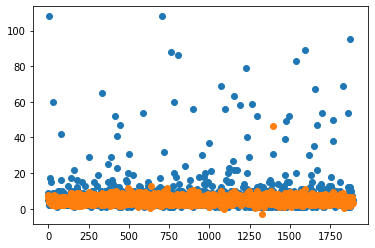

num_convs: 1 num_linears: 1 pool: None {}
MAE: 3.0339997 | RMSE: 8.494128 | MAPE: 45.152539014816284


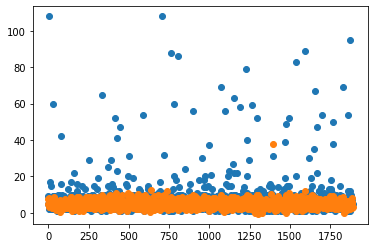

In [ ]:
metrics_to_plot = {"MAE": {}, "RMSE": {}, "MAPE": {}}
for num_convs in cnn_params_to_search["module__num_convs"]:
    for pool in cnn_params_to_search["module__pool"]:
        cnn = CNN(num_convs=num_convs, pool=pool)
        estimator = NeuralNetRegressor(cnn, criterion=nn.SmoothL1Loss, #Smooth1Loss is Huber Loss
                                       max_epochs = 50, batch_size = 32,
                                       callbacks=[clip], device=device, 
                                       verbose=0)
        estimator.initialize()
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        y_true = y_test
        if LOG_DELAYS:
            y_pred = np.exp(y_pred)
            y_true = np.exp(y_test)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        print("MAE:", mae, "|", "RMSE:", rmse, "|", "MAPE:", mape)
        metrics_to_plot["MAE"].setdefault(pool, []).append(mae)
        metrics_to_plot["RMSE"].setdefault(pool, []).append(rmse)
        metrics_to_plot["MAPE"].setdefault(pool, []).append(mape)
        plt.scatter(y_indices, y_true)
        plt.scatter(y_indices, y_pred)
        plt.show()
        break

This cell plots metrics vs number of convolutions and pooling parameters

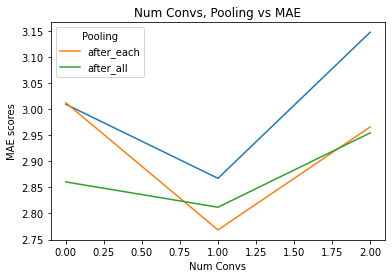

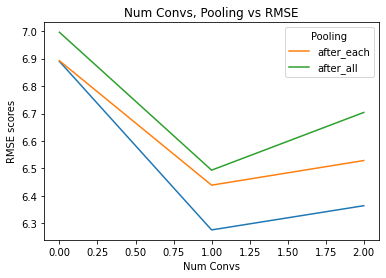

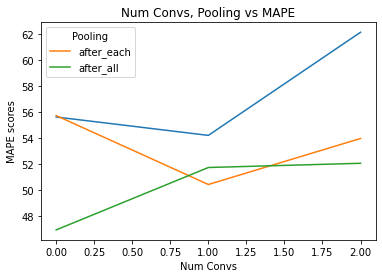

In [ ]:
num_convs = cnn_params_to_search["module__num_convs"] # [0, 1, 2]
pool_types = cnn_params_to_search["module__pool"] #none, after_each, after_all
for metric in metrics_to_plot:
    plt.figure()
    for pool in pool_types:
        test_scores_pool = metrics_to_plot[metric][pool]
        plt.plot(num_convs, test_scores_pool, label=pool)
    plt.title("Num Convs, Pooling vs "+metric)
    plt.xlabel("Num Convs")
    plt.ylabel(metric+" scores")
    plt.legend(title='Pooling', loc='best')
    plt.show()

Grid search over all the paramters and display/plot results.

In [ ]:
cnn_grid_search = GridSearchCV(estimator, search_params,
                               scoring=cnn_metrics, refit=False,
                               return_train_score=False, cv=5)

In [ ]:
cnn_grid_search.fit(X_train, y_train)

num_convs: 0 num_linears: 1 pool: None {'num_lda_topics': 10}
num_convs: 0 num_linears: 1 pool: None {'num_lda_topics': 10}
num_convs: 0 num_linears: 1 pool: None {'num_lda_topics': 10}
num_convs: 0 num_linears: 1 pool: None {'num_lda_topics': 10}
num_convs: 0 num_linears: 1 pool: None {'num_lda_topics': 10}
num_convs: 0 num_linears: 1 pool: None {'num_lda_topics': 10}
num_convs: 0 num_linears: 1 pool: None {'num_lda_topics': 10}
num_convs: 0 num_linears: 1 pool: None {'num_lda_topics': 10}
num_convs: 0 num_linears: 1 pool: None {'num_lda_topics': 10}
num_convs: 0 num_linears: 1 pool: None {'num_lda_topics': 10}
num_convs: 0 num_linears: 1 pool: after_all {'num_lda_topics': 10}
num_convs: 0 num_linears: 1 pool: after_all {'num_lda_topics': 10}
num_convs: 0 num_linears: 1 pool: after_all {'num_lda_topics': 10}
num_convs: 0 num_linears: 1 pool: after_all {'num_lda_topics': 10}
num_convs: 0 num_linears: 1 pool: after_all {'num_lda_topics': 10}
num_convs: 0 num_linears: 1 pool: after_all {

GridSearchCV(cv=5, error_score=nan,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=CNN(
    (conv_layers): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (linear_layers): Sequential(
      (0): Linear(in_features=36160, out_features=1, bias=True)
    )
  ),
),
             iid='deprecated', n_jobs=None,
             param_grid=[{'criterion': [<class 'torch.n...
                          'module__num_lda_topics': [10, 20],
                          'module__pool': [None, 'after_all']}],
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
                      'neg_root_mean_squared_error': 'neg_root_mean_squared_error'},
             verbose=0)

In [ ]:
results = cnn_grid_search.cv_results_

results_df = pd.DataFrame(results)

In [ ]:
results_7_29_20_file = DIR + "delay_prediction/cv_results_log_lda_convs_pool_7_28_20.csv"

In [ ]:
results_df = pd.read_csv(results_7_29_20_file)

In [ ]:
results_df.to_csv(results_7_29_20_file)

In [ ]:
from IPython.display import display

for metric in cnn_metrics:
    display(results_df.sort_values(by='rank_test_'+metric).head(3))

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_module__log_delays,param_module__num_convs,param_module__num_lda_topics,param_module__pool,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,0,30.890790,0.145797,0.060998,0.001315,<class 'torch.nn.modules.loss.SmoothL1Loss'>,False,0,10,NaN,{'criterion': <class 'torch.nn.modules.loss.Sm...,-2.895959,-2.723905,-2.620178,-3.031671,-2.585900,-2.771522,0.168991,1,-7.882117,-7.116867,-6.967162,-8.501788,-6.753809,-7.444349,0.651401,11,-46.354222,-48.927754,-46.215773,-47.397694,-47.993296,-47.377748,1.017802,3
2,2,30.894294,0.050454,0.061376,0.001258,<class 'torch.nn.modules.loss.SmoothL1Loss'>,False,0,20,NaN,{'criterion': <class 'torch.nn.modules.loss.Sm...,-2.907976,-2.726988,-2.626713,-3.035502,-2.597956,-2.779027,0.167989,2,-7.912694,-7.143770,-6.990664,-8.526443,-6.781129,-7.470940,0.651579,12,-46.328509,-48.841017,-46.015108,-47.201478,-48.141474,-47.305517,1.066500,2
1,1,31.825614,0.146230,0.065660,0.001678,<class 'torch.nn.modules.loss.SmoothL1Loss'>,False,0,10,after_all,{'criterion': <class 'torch.nn.modules.loss.Sm...,-2.968714,-2.799273,-2.675830,-3.056837,-2.659770,-2.832085,0.157712,3,-8.085806,-7.275968,-7.052957,-8.630808,-6.865454,-7.582199,0.669447,15,-46.655461,-49.481556,-46.736848,-48.602286,-47.765630,-47.848356,1.086374,4


,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_module__log_delays,param_module__num_convs,param_module__num_lda_topics,param_module__pool,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
14,14,40.995076,0.125476,0.079617,0.001388,<class '__main__.LogHuberLoss'>,True,1,20,NaN,"{'criterion': <class '__main__.LogHuberLoss'>,...",-3.092285,-2.826835,-2.864419,-3.496049,-2.936451,-3.043208,0.243989,16,-7.728328,-6.855965,-6.624840,-7.914584,-6.326144,-7.089972,0.623221,1,-51.398069,-44.856387,-54.587901,-69.080275,-63.558739,-56.696274,8.638936,16
12,12,40.703278,0.083922,0.079057,0.000797,<class '__main__.LogHuberLoss'>,True,1,10,NaN,"{'criterion': <class '__main__.LogHuberLoss'>,...",-3.118163,-2.897743,-2.875968,-3.270459,-2.731660,-2.978798,0.191160,15,-7.731101,-6.612744,-6.576982,-8.093686,-6.462354,-7.095374,0.678698,2,-46.518159,-56.789476,-55.436164,-60.762793,-50.152785,-53.931875,5.026627,13
13,13,42.694966,0.201401,0.083581,0.003222,<class '__main__.LogHuberLoss'>,True,1,10,after_all,"{'criterion': <class '__main__.LogHuberLoss'>,...",-3.062761,-2.811834,-2.734406,-3.273712,-2.737647,-2.924072,0.212041,13,-7.615706,-6.804935,-6.627779,-8.065169,-6.486840,-7.120086,0.613434,3,-51.439822,-48.928609,-50.132030,-59.424615,-50.023133,-51.989642,3.801813,10


,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_module__log_delays,param_module__num_convs,param_module__num_lda_topics,param_module__pool,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
3,3,31.890407,0.157898,0.065738,0.003920,<class 'torch.nn.modules.loss.SmoothL1Loss'>,False,0,20,after_all,{'criterion': <class 'torch.nn.modules.loss.Sm...,-2.980315,-2.800541,-2.670015,-3.056820,-2.661767,-2.833892,0.160457,4,-8.107554,-7.303682,-7.069633,-8.656444,-6.884972,-7.604457,0.671408,16,-46.333945,-48.735642,-45.959029,-48.030454,-47.317532,-47.275320,1.031830,1
2,2,30.894294,0.050454,0.061376,0.001258,<class 'torch.nn.modules.loss.SmoothL1Loss'>,False,0,20,NaN,{'criterion': <class 'torch.nn.modules.loss.Sm...,-2.907976,-2.726988,-2.626713,-3.035502,-2.597956,-2.779027,0.167989,2,-7.912694,-7.143770,-6.990664,-8.526443,-6.781129,-7.470940,0.651579,12,-46.328509,-48.841017,-46.015108,-47.201478,-48.141474,-47.305517,1.066500,2
0,0,30.890790,0.145797,0.060998,0.001315,<class 'torch.nn.modules.loss.SmoothL1Loss'>,False,0,10,NaN,{'criterion': <class 'torch.nn.modules.loss.Sm...,-2.895959,-2.723905,-2.620178,-3.031671,-2.585900,-2.771522,0.168991,1,-7.882117,-7.116867,-6.967162,-8.501788,-6.753809,-7.444349,0.651401,11,-46.354222,-48.927754,-46.215773,-47.397694,-47.993296,-47.377748,1.017802,3


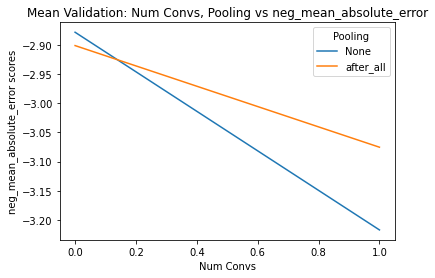

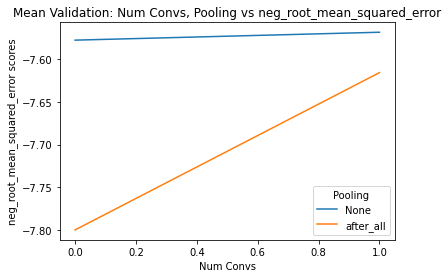

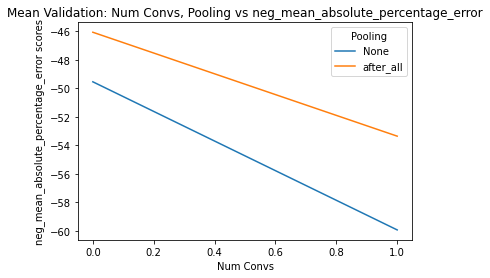

In [ ]:
num_convs = cnn_params_to_search["module__num_convs"] # [0, 1, 2]
pool_types = cnn_params_to_search["module__pool"] #none, after_each, after_all
for metric in cnn_metrics:
    plt.figure()
    for pool in pool_types:
        pool_select = results["param_module__pool"] == pool
        #train_scores_pool = results["mean_train_"+metric][pool_select]
        test_scores_pool = results["mean_test_"+metric][pool_select]
        plt.plot(num_convs, test_scores_pool, label=str(pool))
    plt.title("Mean Validation: Num Convs, Pooling vs "+metric)
    plt.xlabel("Num Convs")
    plt.ylabel(metric+" scores")
    plt.legend(title='Pooling', loc='best')
    plt.show()